In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import os
import math
import random
from torchsummary import summary

from dataset import PEDataset, PEFeatureSequenceDataset
from model import PEFeatureSequentialNet
from utils import Timer, AverageMeter

## Hyperparameters

In [2]:
load_sequential_model = 'new/sequence_r3d_18_chunk10_ep10_new_splits_batch64_tcn_bn_dropout0.2_hsize128_level2/epoch13.pth'
feature_dir = 'test/features/new/r3d_18_chunk10_batch16_epoch10_new_splits'
gpu = 0
pos_weight = 1.
dropout = 0.2
batch_size = 1
chunk_size = 10
seq_model = 'TCN'
seq_len = 40
feature_size = 512
hidden_size = 128
levels = 2
kernel_size = 3
diff = True
maxpool = True
batchnorm = False
bidirectional = False

## Data Splits

In [3]:
with open('data/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

test_paths = data_splits['test_paths']
print("test {}".format(len(test_paths)))

test 1000


## Set Dataset

In [4]:
test_set_s2 = PEFeatureSequenceDataset(paths=test_paths, 
                                       feature_dir=feature_dir, 
                                       mode='test', 
                                       chunk_size=chunk_size,
                                       seq_len=seq_len, 
                                       diff=diff)

print("step 2 test set length: {}".format(len(test_set_s2)))

test_loader_s2 = DataLoader(test_set_s2, batch_size=1, shuffle=False)
print("step 2 test loader iters: {}".format(len(test_loader_s2)))

100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]

step 2 test set length: 1000
step 2 test loader iters: 1000


## Test Model

In [5]:
if load_sequential_model == '':
    model = PEFeatureSequentialNet(seq_model=seq_model, 
                                   input_size=feature_size,
                                   hidden_size=hidden_size,
                                   levels=levels, 
                                   kernel_size=kernel_size, 
                                   seq_len=seq_len,
                                   dropout=dropout, 
                                   bidirectional=bidirectional, 
                                   maxpool=maxpool, 
                                   diff=diff, 
                                   batchnorm=batchnorm)
else:
    model = PEFeatureSequentialNet(seq_model=seq_model, 
                                   input_size=feature_size,
                                   hidden_size=hidden_size,
                                   levels=levels, 
                                   kernel_size=kernel_size, 
                                   seq_len=seq_len,
                                   dropout=dropout, 
                                   bidirectional=bidirectional, 
                                   maxpool=maxpool, 
                                   diff=diff, 
                                   batchnorm=batchnorm)
    model.load_state_dict(torch.load("weights/"+load_sequential_model))

criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.tensor([pos_weight]))
criterion_exam_level = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

print('')
print("Use cuda " + str(gpu))
print('')
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)
criterion.to(device)
criterion_exam_level.to(device)

label_list = [
    'pe_present_on_image',
    'negative_exam_for_pe',
    'indeterminate',
    'chronic_pe',
    'acute_and_chronic_pe',
    'central_pe',
    'leftsided_pe',
    'rightsided_pe',
    'rv_lv_ratio_gte_1',
    'rv_lv_ratio_lt_1'
]

loss_weight_dict = {
    'pe_present_on_image': 0.07361963,
    'negative_exam_for_pe': 0.0736196319,
    'indeterminate': 0.09202453988,
    'chronic_pe': 0.1042944785,
    'acute_and_chronic_pe': 0.1042944785,
    'central_pe': 0.1877300613,
    'leftsided_pe': 0.06257668712,
    'rightsided_pe': 0.06257668712,
    'rv_lv_ratio_gte_1': 0.2346625767,
    'rv_lv_ratio_lt_1': 0.0782208589
}

timer = Timer()

# evaluation
print('Test:')
model.eval()

losses = {label: AverageMeter() for label in label_list}
losses['total'] = AverageMeter()
accs = {label: AverageMeter() for label in label_list}
aucs = {label: 0. for label in label_list}
y_trues = {label: [] for label in label_list}
y_scores = {label: [] for label in label_list}

timer.start()

for batch, data in enumerate(test_loader_s2):
    with torch.no_grad():
        x, mask = data[0], data[1]
        labels = {label_list[i]:data[i+2] for i in range(len(label_list))}
        q_i, series_len = data[-2], data[-1]  # q_i, series_len: (batch_size, )

        adjustment = [series_len[i].item() / seq_len if series_len[i] > seq_len else 1. for i in range(x.size(0))]
        adjustment = torch.tensor(adjustment, dtype=torch.float32)  # (batch_size, )
        loss_weight_pe = torch.tensor(loss_weight_dict['pe_present_on_image'], dtype=torch.float32)
        loss_pe_weights = loss_weight_pe * q_i * adjustment  # (batch_size, )
        loss_pe_weights = loss_pe_weights.unsqueeze(1).to(device)  # (batch, 1)

        x = x.to(device)  # (batch, seq_len, feature_size)
        mask = mask.to(device)  # (batch, seq_len)
        for key in label_list:
            labels[key] = labels[key].float().to(device)

        logits = model(x, mask)

        loss_dict = {label: 0. for label in label_list}

        # window level loss
        # logits['pe_present_on_image']: (batch_size, seq_len, 1)
        # labels['pe_present_on_image']: (batch_size, seq_len)
        loss_dict['pe_present_on_image'] = criterion(logits['pe_present_on_image'].squeeze(-1), 
                                                     labels['pe_present_on_image'])  # (batch_size, seq_len)
        loss_dict['pe_present_on_image'] = loss_dict['pe_present_on_image'] * mask * loss_pe_weights
        loss_dict['pe_present_on_image'] = loss_dict['pe_present_on_image'].sum() / mask.sum()
        # study level loss
        for key in label_list[1:]:
            loss_dict[key] = criterion_exam_level(logits[key].view(-1), labels[key]) * loss_weight_dict[key]

        total_loss = 0
        total_weight = 0
        # window level loss
        losses['pe_present_on_image'].update(loss_dict['pe_present_on_image'].item(), mask.sum().item())
        total_loss += loss_dict['pe_present_on_image'].item() * mask.sum().item()
        total_weight += (mask * loss_pe_weights).sum().item()
        # study level loss
        for key in label_list[1:]:
            losses[key].update(loss_dict[key].item(), x.size(0))
            total_loss += loss_dict[key].item() * x.size(0)
            total_weight += loss_weight_dict[key] * x.size(0)
        losses['total'].update(total_loss / total_weight, total_weight)

        # window level evaluations
        # mask: (batch, seq_len)
        # logits['pe_present_on_image']: (batch_size, seq_len, 1)
        # labels['pe_present_on_image']: (batch_size, seq_len)
        logits_pe = []
        labels_pe = []
        for i, m in enumerate(mask):
            logits_pe.extend(logits['pe_present_on_image'].detach().cpu().squeeze(-1)[i][:int(m.sum().item())].tolist())
            labels_pe.extend(labels['pe_present_on_image'].detach().cpu()[i][:int(m.sum().item())].tolist())
        pred_prob = torch.tensor(logits_pe).sigmoid().numpy()
        label = np.array(labels_pe)
        accs['pe_present_on_image'].update(sum((pred_prob > 0.5) == label) / mask.sum().item(), mask.sum().item())
        y_scores['pe_present_on_image'].extend(pred_prob.tolist())
        y_trues['pe_present_on_image'].extend(np.round(label).tolist())
        # study level evaluations
        for key in label_list[1:]:
            pred_prob = np.squeeze(logits[key].detach().sigmoid().cpu().numpy(), axis=-1)
            label = labels[key].detach().cpu().numpy()
            accs[key].update(sum((pred_prob > 0.5) == label) / x.size(0), x.size(0))
            y_scores[key].extend(pred_prob.tolist())
            y_trues[key].extend(label.tolist())

timer.stop()

# calculate AUCs
for key in label_list:
    try:
        aucs[key] = roc_auc_score(y_trues[key], y_scores[key])
    except:
        pass

# report losses, accuracies, AUCs of each epoch
for key in label_list:
    print('{:>20}: loss {:.4f} | Acc {:.4f} | AUC {:.4f}'.format(key, 
                                                                 losses[key].avg,
                                                                 accs[key].avg, 
                                                                 aucs[key]))
print('Total loss: {:4f}'.format(losses['total'].avg))


Use cuda 0

Test:
 pe_present_on_image: loss 0.0020 | Acc 0.9514 | AUC 0.9258
negative_exam_for_pe: loss 0.0248 | Acc 0.8810 | AUC 0.8936
       indeterminate: loss 0.0084 | Acc 0.9820 | AUC 0.8619
          chronic_pe: loss 0.0171 | Acc 0.9590 | AUC 0.6866
acute_and_chronic_pe: loss 0.0089 | Acc 0.9790 | AUC 0.8580
          central_pe: loss 0.0216 | Acc 0.9550 | AUC 0.9477
        leftsided_pe: loss 0.0180 | Acc 0.8920 | AUC 0.8918
       rightsided_pe: loss 0.0172 | Acc 0.9010 | AUC 0.9233
   rv_lv_ratio_gte_1: loss 0.0580 | Acc 0.9010 | AUC 0.8708
    rv_lv_ratio_lt_1: loss 0.0261 | Acc 0.8610 | AUC 0.8511
Total loss: 0.217671


## Plot Test Thresholds

In [6]:
sensitivity = {label: [] for label in label_list}
specificity = {label: [] for label in label_list}

for threshold in np.linspace(0.0, 1.0, 21):
    for key in label_list:
        y_preds = (y_scores[key] >= threshold) * 1.
        tn, fp, fn, tp = confusion_matrix(y_trues[key], y_preds).ravel()
        sensitivity[key].append(tp/(tp+fn))
        specificity[key].append(tn/(tn+fp))

In [7]:
def plot_sensitivity_specificity(label, ax):
    #plt.figure(figsize=(8,4))
    x = np.round(np.linspace(0.0, 1.0, 21), decimals=2)
    width = 0.4
    ax.bar(np.arange(len(x))-width/2, sensitivity[label], width=width, label='sensitivity')
    ax.bar(np.arange(len(x))+width/2, specificity[label], width=width, label='specificity')
    ax.set_xlabel('Probability threshold', fontsize=16)
    if label == 'pe_present_on_image':
        ax.set_xticks(ticks=np.arange(21))
        ax.set_xticklabels(labels=x, rotation=30, fontsize=12)
    else: 
        ax.set_xticks(ticks=np.arange(0, 21, 2))
        ax.set_xticks(ticks=np.arange(1, 20, 2), minor=True)
        ax.set_xticklabels(labels=x[0::2], rotation=45, fontsize=12)
    ax.set_yticks(ticks=np.linspace(0.0, 1.0, 6))
    ax.set_yticks(ticks=np.linspace(0.1, 0.9, 5), minor=True)
    ax.set_yticklabels(labels=np.around(np.linspace(0.0, 1.0, 6), decimals=1), fontsize=14)
    plt.legend()
    if label == 'pe_present_on_image':
        ax.set_title('pe_present_on_window', fontsize=18)
    else:
        ax.set_title(label, fontsize=18)
    if label == 'pe_present_on_image':
        for a, b in zip(np.arange(len(x))-width/2, sensitivity[label]):
            plt.text(a-0.1, b, '%.2f'%b, ha='center', va='bottom', fontsize=10)
        for a, b in zip(np.arange(len(x))+width/2, specificity[label]):
            plt.text(a+0.1, b, '%.2f'%b, ha='center', va='bottom', fontsize=10)
    ax.grid(which='both', axis='y', alpha=0.5, linestyle='dashed')
#     plt.tight_layout()
#     plt.show()

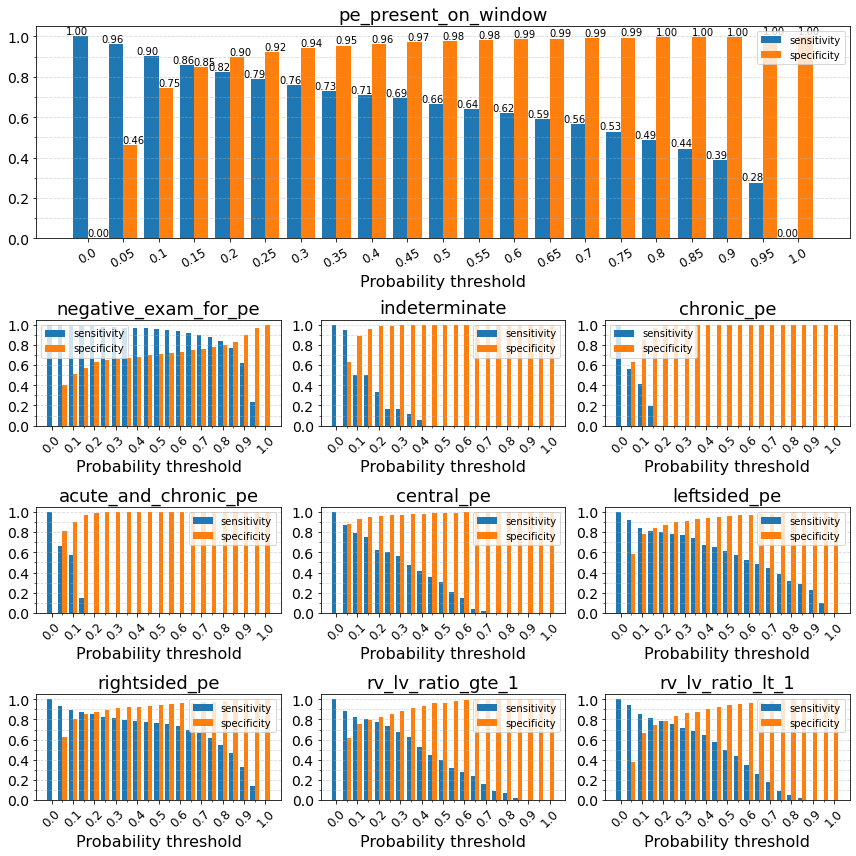

In [8]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
gs = gridspec.GridSpec(4, 3, height_ratios=(2, 1, 1, 1))
ax = fig.add_subplot(gs[0, :])
plot_sensitivity_specificity(label_list[0], ax)
for i, label in enumerate(label_list[1:]):
    ax = fig.add_subplot(gs[i//3+1, i%3])
    plot_sensitivity_specificity(label, ax)
#fig.savefig('plot_sense_speci.svg', format='svg')
plt.show()

## Plot AUROC

In [9]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for label in label_list:
    fpr[label], tpr[label], _ = roc_curve(y_trues[label], y_scores[label])
    roc_auc[label] = auc(fpr[label], tpr[label])

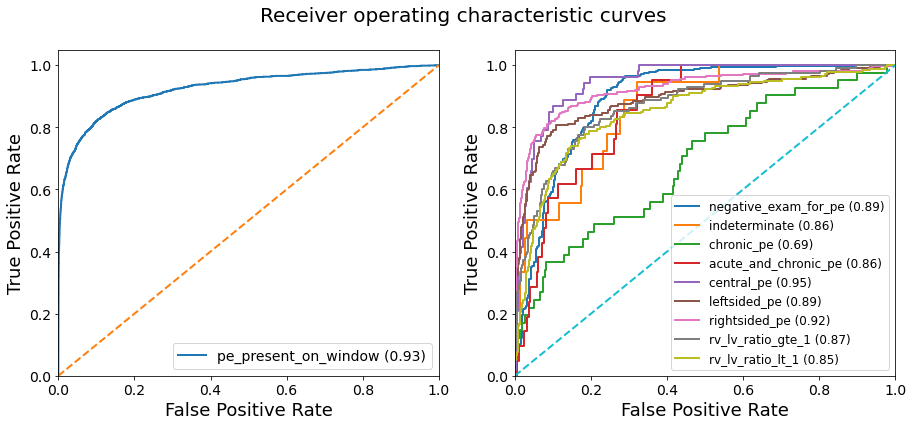

In [10]:
plt.figure(figsize=(15, 6))
plt.suptitle('Receiver operating characteristic curves', fontsize=20)
plt.subplot(121)
lw = 2
label = 'pe_present_on_image'
plt.plot(fpr[label], tpr[label], lw=lw, 
         label='{} ({:0.2f})'.format('pe_present_on_window', roc_auc[label]))
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={'size': 14})

#plt.figure(figsize=(8, 6))
plt.subplot(122)
lw = 2
label = ''
for label in label_list[1:]:
    plt.plot(fpr[label], tpr[label], lw=lw, 
             label='{} ({:0.2f})'.format(label, roc_auc[label]))
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={'size': 12})

#plt.savefig('plot_aucs.svg', format='svg')
plt.show()

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

ci = {label:None for label in label_list}
for label in label_list:
#     fpr[label], tpr[label], _ = roc_curve(y_trues[label], y_scores[label])
#     roc_auc[label] = auc(fpr[label], tpr[label])

    print(label)

    alpha = .95
    y_pred = np.array(y_scores[label])
    y_true = np.array(y_trues[label])

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci[label] = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[label][ci[label] > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci[label])

pe_present_on_image
AUC: 0.9257846502772866
AUC COV: 1.4686822669169537e-05
95% AUC CI: [0.9182734 0.9332959]
negative_exam_for_pe
AUC: 0.8936246401681618
AUC COV: 0.00015457836924118523
95% AUC CI: [0.8692565  0.91799278]
indeterminate
AUC: 0.8619031455080336
AUC COV: 0.0013405974031784334
95% AUC CI: [0.79014069 0.9336656 ]
chronic_pe
AUC: 0.6865891808031741
AUC COV: 0.0019756775874849456
95% AUC CI: [0.59947154 0.77370683]
acute_and_chronic_pe
AUC: 0.8580183861082737
AUC COV: 0.0008415578200307333
95% AUC CI: [0.80116058 0.91487619]
central_pe
AUC: 0.9477396345958438
AUC COV: 0.00012002202289547746
95% AUC CI: [0.92626733 0.96921193]
leftsided_pe
AUC: 0.8918099337262478
AUC COV: 0.00022783333367158714
95% AUC CI: [0.86222595 0.92139392]
rightsided_pe
AUC: 0.9232874968169085
AUC COV: 0.000130315802591088
95% AUC CI: [0.90091334 0.94566165]
rv_lv_ratio_gte_1
AUC: 0.8707639400638663
AUC COV: 0.0003412576711212839
95% AUC CI: [0.83455721 0.90697067]
rv_lv_ratio_lt_1
AUC: 0.8510704607046